In [1]:
%cd ~/cdv/

import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import wat
from eins import EinsOp
import treescope


is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/nmiklaucic/cdv


In [2]:
from facet.data.dataset import load_file
from pathlib import Path
import pyrallis
from facet.config import MainConfig
import orbax.checkpoint as ocp

from facet.training_state import TrainingRun
from facet.checkpointing import best_ckpt

conf_file = 'configs/small.toml'

with open(conf_file) as f:
    config = pyrallis.cfgparsing.load(MainConfig, f)

config.device.device = 'cpu'

cg = load_file(config, 0, 0)

2024-10-04 15:45:56.450545: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/jax/_src/xla_bridge.py:885 in │
│ backends                                                                                         │
│                                                                                                  │
│    882 │   │   if platform == "cuda" and not hardware_utils.has_visible_nvidia_gpu():            │
│    883 │   │     continue                                                                        │
│    884 │   │                                                                                     │
│ ❱  885 │   │   backend = _init_backend(platform)                                                 │
│    886 │   │   _backends[platform] = backend                                                     │
│    887 │   │                                                                                     │
│    888 │   │   if priority > default_priority:                                                   │
│                                                                                                  │
│ /home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/jax/_src/xla_bridge.py:971 in │
│ _init_backend                                                                                    │
│                                                                                                  │
│    968 │   logger.warning(f"Platform '{platform}' is experimental and not all JAX "              │
│    969 │   │   │   │      "functionality may be correctly supported!")                           │
│    970   logger.debug("Initializing backend '%s'", platform)                                     │
│ ❱  971   backend = registration.factory()                                                        │
│    972   # TODO(skye): consider raising more descriptive errors directly from backend            │
│    973   # factories instead of returning None.                                                  │
│    974   if backend is None:                                                                     │
│                                                                                                  │
│ /home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/jax/_src/xla_bridge.py:671 in │
│ factory                                                                                          │
│                                                                                                  │
│    668 │     updated_options.update(options)                                                     │
│    669 │   updated_options.update(_options_from_jax_configs(plugin_name))                        │
│    670 │   if distributed.global_state.client is None:                                           │
│ ❱  671 │     return xla_client.make_c_api_client(plugin_name, updated_options, None)             │
│    672 │                                                                                         │
│    673 │   distribute_options = {                                                                │
│    674 │   │   'node_id': distributed.global_state.process_id,                                   │
│                                                                                                  │
│ /home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/jaxlib/xla_client.py:200 in   │
│ make_c_api_client                                                                                │
│                                                                                                  │
│   197   """                                                                                      │
│   198   if options is None:                                                                      │
│   199 │   options = {}                                     

In [7]:
import networkx as nx
from facet.data.dataset_generation import parse_data_id_mp2022
from pymatgen.core import Element

from facet.data.databatch import CrystalGraphs
from eins import EinsOp, Reductions as R


def edge_vecs(cg):
    """CG -> nodes k xyz"""
    # print(cg)
    send_pos = cg.nodes.cart[:, None, :]  # nodes 1 3
    # print(cg.graph_data.lat[cg.nodes.graph_i].shape, cg.edges.to_jimage.shape)
    offsets = EinsOp('nodes abc xyz, nodes k abc -> nodes k xyz')(
        cg.graph_data.lat[cg.nodes.graph_i], cg.edges.to_jimage
    )
    recv_pos = cg.nodes.cart[cg.receivers] + offsets  # nodes k 3
    vecs = recv_pos - send_pos
    return vecs


def nx_graphs(cg: CrystalGraphs, rmax=np.inf):
    ans = []
    dists = np.array(R.l2_norm(edge_vecs(cg), axis=-1))
    for graph_i, n in enumerate(cg.n_node):
        if cg.padding_mask[graph_i]:
            mask = cg.nodes.graph_i == graph_i
            G = nx.MultiDiGraph()
            for i, s in zip(np.where(mask)[0], cg.nodes.species[mask]):
                G.add_node(
                    i, species=Element.from_Z(config.data.metadata.atomic_numbers[s].item()).symbol
                )

            for G_i, n_i in enumerate(np.where(mask)[0]):
                for n_j, dist in zip(cg.edges.receiver[n_i], dists[n_i]):
                    if dist.item() < rmax:
                        G.add_edge(n_i, n_j.item(), dist=dist.item())

            G.graph['dataset_id'] = parse_data_id_mp2022(cg.graph_data.dataset_id[graph_i].item())

            ans.append(G)

    return ans


def radii(cg: CrystalGraphs | list):
    if isinstance(cg, CrystalGraphs):
        graphs = nx_graphs(cg)
    else:
        graphs = cg
    ans = []
    for G in graphs:
        try:
            ans.append(nx.radius(G))
        except nx.NetworkXError as e:
            if 'not strongly connected' in str(e):
                ans.append(np.inf)
            else:
                raise e

    return np.array(ans)


graphs = []

for i in range(100):
    cg = load_file(config, 5, i)
    graphs.extend(nx_graphs(cg, rmax=np.inf))

rads = radii(graphs)
rads = np.hstack(rads)
np.unique(rads, return_counts=True)


(
    array([ 1.,  2.,  3.,  4.,  5.,  7.,  8.,  9., 19., inf]),
    array([2404,  603,   63,   10,    2,    1,    2,    1,    1,    2])
)

In [18]:
vecs = edge_vecs(cg)
dists = np.array(R.l2_norm(vecs, axis=-1))

dm = dists[cg.nodes.graph_i == 20].round(2)
dm


array([[ 2.36,  2.36,  4.62,  4.62,  6.88,  6.88,  9.25,  9.25,  9.83,
         9.83,  9.83,  9.83, 10.09, 10.09, 10.09, 10.09, 10.09, 10.09,
        10.09, 10.09, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87,
        10.87, 11.52, 11.52, 11.61, 11.61],
       [ 2.26,  2.36,  4.52,  4.72,  6.88,  6.99,  9.25,  9.25,  9.83,
         9.83,  9.83,  9.83, 10.09, 10.09, 10.09, 10.09, 10.11, 10.11,
        10.11, 10.11, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87,
        10.87, 11.51, 11.52, 11.52, 11.61],
       [ 2.26,  2.36,  4.52,  4.72,  6.88,  6.99,  9.25,  9.25,  9.83,
         9.83,  9.83,  9.83, 10.09, 10.09, 10.09, 10.09, 10.11, 10.11,
        10.11, 10.11, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87,
        10.87, 11.51, 11.52, 11.52, 11.61],
       [ 2.26,  2.26,  4.62,  4.62,  6.99,  6.99,  9.25,  9.25,  9.83,
         9.83,  9.83,  9.83, 10.11, 10.11, 10.11, 10.11, 10.11, 10.11,
        10.11, 10.11, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87, 10.87,
        10.87, 

In [9]:
n_nodes = np.array([len(G.nodes) for G in graphs])
print(np.nonzero(np.isposinf(rads))[0])
print([g.graph['dataset_id'] for g, r in zip(graphs, rads) if np.isposinf(r)])
n_nodes[np.isposinf(rads)]

[1457 1705]
['mp-1207373-GGA', 'mp-1213171-GGA']


array([10, 10])

In [12]:
list(nx.strongly_connected_components(G))

[{291, 293, 294, 297, 298, 299, 300}, {296, 292, 295}]

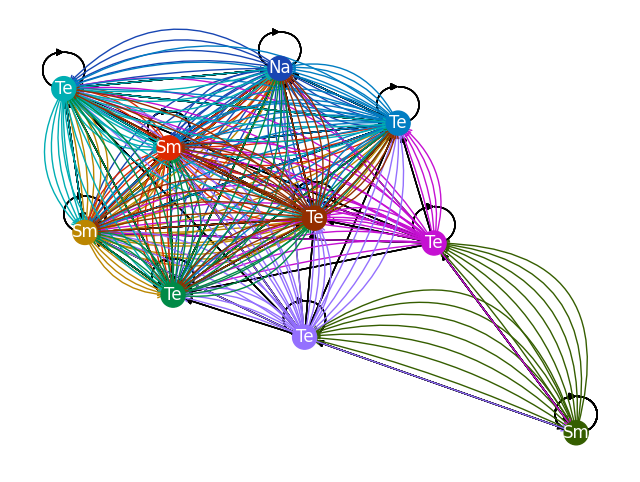

In [10]:
from itertools import cycle
G = graphs[1457]


# nx.draw_networkx_nodes(G, pos=pos, node_color=cs[0])
# nx.draw_networkx_labels(G, labels=dict(G.nodes.data('species')), font_color=plt.rcParams['axes.facecolor'], pos=pos)
# nx.draw_networkx_edges(G, pos=pos)
# labels = {
#     tuple(edge): f"{attrs['dist']:.2f}"
#     for *edge, attrs in G.edges(keys=True, data=True)
# }
# nx.draw_networkx_edge_labels(G, edge_labels=labels, pos=pos)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, alpha=1, with_labels=False, node_color=[cs[i % len(cs)] for i in range(len(G.nodes))])
# nx.draw_networkx_nodes()
nx.draw_networkx_labels(G, labels=dict(G.nodes.data('species')), font_color=plt.rcParams['axes.facecolor'], pos=pos)
ax = plt.gca()
for e in G.edges:
    ax.annotate(
        '',
        xy=pos[e[1]],
        xycoords='data',
        xytext=pos[e[0]],
        textcoords='data',
        arrowprops=dict(
            arrowstyle='->',
            color=cs[list(G.nodes).index(e[0]) % len(cs)],
            shrinkA=5,
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle='arc3,rad=rrr'.replace('rrr', str(0.1 * e[2] + 0.05 * int(e[0] < e[1]))),
        ),
        zorder=1
    )

plt.axis('off')
plt.show()

In [83]:
for comp in list(nx.strongly_connected_components(G)):
    for n in comp:
        print(G.nodes.data('species')[n], end=' ')
    print()

Na Sm Sm Te Te Te Te 
Te Sm Te 


In [31]:
import pickle
with open('/home/nmiklaucic/mat-graph/crystallographic_graph/knns_mp2022/batch_0000.pkl', 'rb') as f:
    knns = pickle.load(f)

df = pd.read_pickle('/home/nmiklaucic/cdv/precomputed/mp2022/raw/batch_0000.pkl')

len(knns)

4298

In [32]:
np.where(df['dataset-id'].str.contains('1224682'))

(array([], dtype=int64),)

In [ ]:
cg.cart

In [216]:
cg.cart[cg.nodes.graph_i == 8].round(2)


Array([[ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , 16.27    ],
       [ 0.      ,  0.      ,  8.12    ],
       [ 0.      ,  1.99    ,  2.1     ],
       [ 1.99    , -0.      ,  6.1     ],
       [ 0.      ,  1.99    , 10.09    ],
       [ 1.99    ,  0.      ,  2.1     ],
       [-0.      ,  1.99    ,  6.1     ],
       [ 1.99    ,  0.      , 10.09    ],
       [ 0.      ,  0.      , 12.2     ],
       [ 0.      ,  0.      ,  4.1     ],
       [ 0.      ,  0.      , 20.289999]], dtype=float32)

In [239]:
def knn_graph(struct, r_start=8, k=16):
    """returns (ijs, ims)
    ijs: nodes k
    ims: nodes k 3"""
    if r_start > 100:
        raise ValueError()
    graph_ijs = []
    graph_ims = []
    r = r_start
    
    for i, nbs in enumerate(struct.get_all_neighbors(r)):
        sites, dists, idxs, ims = zip(*nbs)
        if len(dists) < k:
            # print('Not enough neighbors, using r =', 2 * r_start)
            return knn_graph(struct, r_start=r * 2, k=k)
        
        chosen = np.argsort(dists)[:k]
        if i == 0:
            print(dists[chosen[-1]])

        graph_ijs.append(np.array(idxs)[chosen])
        graph_ims.append(np.array(ims)[chosen])

    graph_ijs = np.stack(graph_ijs).astype(np.uint16)
    graph_ims = np.stack(graph_ims).astype(np.int8)

    return {'ims': np.array(graph_ims), 'ijs': np.array(graph_ijs)}

edges2 = knn_graph(mat)

edges2['ijs'][0]

3.970896


array([9, 9, 9, 9, 8, 5, 8, 5, 3, 6, 6, 3, 0, 0, 0, 0], dtype=uint16)

In [243]:
mat


Structure Summary
Lattice
    abc : 12.514141593665464 12.514141593665464 12.514141593665464
 angles : 161.7421711097441 161.7421711097441 25.93213484667798
 volume : 192.29204720819413
      A : -1.985448 1.985448 12.19507
      B : 1.985448 -1.985448 12.19507
      C : 1.985448 1.985448 -12.19507
    pbc : True True True
PeriodicSite: Zr (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Nb (0.0, 0.0, 16.27) [0.6669, 0.6669, 0.0]
PeriodicSite: Nb (0.0, 0.0, 8.124) [0.3331, 0.3331, 0.0]
PeriodicSite: Pd (0.0, 1.985, 2.101) [0.5861, 0.08614, 0.5]
PeriodicSite: Pd (1.985, -1.11e-16, 6.098) [0.25, 0.75, 0.5]
PeriodicSite: Pd (0.0, 1.985, 10.09) [0.9139, 0.4139, 0.5]
PeriodicSite: Pd (1.985, 0.0, 2.101) [0.08614, 0.5861, 0.5]
PeriodicSite: Pd (-1.11e-16, 1.985, 6.098) [0.75, 0.25, 0.5]
PeriodicSite: Pd (1.985, 0.0, 10.09) [0.4139, 0.9139, 0.5]
PeriodicSite: Pd (0.0, 0.0, 12.2) [0.5, 0.5, 0.0]
PeriodicSite: Pd (0.0, 0.0, 4.103) [0.1682, 0.1682, 0.0]
PeriodicSite: Pd (0.0, 0.0, 20.29) [0.8318, 

In [255]:
from pymatgen.core import Structure

matf = Structure(mat.lattice.matrix, mat.species, mat.frac_coords)

[n.index for n in matf.get_neighbors(matf.sites[0], r=5, include_index=True, include_image=True)]

[2, 8, 5, 9, 1, 6, 3, 5, 2, 8, ... +32]

In [242]:
ijs


array([11, 10,  2,  1,  9,  9,  1,  2,  9,  9,  2,  1,  1,  2, 10, 10],
      dtype=uint16)

In [218]:
cg.nodes.cart[cg.edges.receiver[0]]


Array([[ 2.3600771,  7.8271894,  5.6958647],
       [ 2.357871 , 10.216371 ,  9.906325 ],
       [ 4.629563 , 11.2923975,  6.8879447],
       [ 4.7815356,  6.876531 ,  8.645217 ],
       [ 1.3406546,  8.172276 ,  9.201895 ],
       [ 5.538538 ,  9.315582 ,  6.038395 ],
       [ 5.567232 ,  8.902307 ,  9.507471 ],
       [ 1.2719568,  9.825546 ,  6.3801184],
       [ 3.3304338, 10.166206 ,  4.8659425],
       [ 3.4251168,  7.8895054, 10.687534 ],
       [ 4.4082355, 12.424771 , 10.632764 ],
       [ 4.6036196,  5.590589 ,  4.872688 ],
       [ 2.5732498,  5.2968025, 10.632764 ],
       [ 2.377866 , 12.718558 ,  4.872688 ],
       [ 4.593985 ,  8.7819605,  2.8822308],
       [ 2.3519228,  4.164428 ,  6.8879447]], dtype=float32)

In [226]:
ims[0] @ lat

Array([  0.     ,   0.     , -24.39014], dtype=float32)

In [221]:
offsets


Array([[ 0.      ,  0.      , -3.970896],
       [ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -3.970896],
       [ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -3.970896],
       [ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -3.970896],
       [ 1.985448, -1.985448, -1.985448],
       [-1.985448,  1.985448, -1.985448],
       [ 1.985448, -1.985448, -1.985448],
       [ 1.985448, -1.985448, -1.985448],
       [-1.985448,  1.985448, -1.985448],
       [-1.985448,  1.985448, -1.985448],
       [ 1.985448, -1.985448, -1.985448],
       [-1.985448,  1.985448, -1.985448]], dtype=float32)

In [229]:
ims = knns[1608]['ims'][0]
ijs = knns[1608]['ijs'][0]

o = cg.nodes.cart[cg.nodes.graph_i == 8][0]
lat = cg.graph_data.lat[8]
offsets = ims @ lat
cg.nodes.cart[cg.edges.receiver[cg.nodes.graph_i == 8][0]] + offsets


Array([[  0.       ,   0.       ,  -4.102787 ],
       [  0.       ,   0.       ,   4.1027875],
       [  0.       ,   0.       ,   8.123819 ],
       [  0.       ,   0.       ,  -8.123819 ],
       [  0.       ,   0.       ,  12.19507  ],
       [  0.       ,   0.       , -12.19507  ],
       [  0.       ,   0.       ,  16.266321 ],
       [  0.       ,   0.       , -16.266321 ],
       [  1.985448 ,  -1.985448 ,   0.       ],
       [ -1.985448 ,   1.985448 ,   0.       ],
       [  1.985448 ,  -1.985448 ,  -4.071251 ],
       [  1.985448 ,  -1.985448 ,   4.071251 ],
       [ -1.985448 ,   1.985448 ,   4.071251 ],
       [ -1.985448 ,   1.985448 ,  -4.071251 ],
       [  1.985448 ,  -1.985448 ,  -8.092283 ],
       [ -1.985448 ,   1.985448 ,  -8.092283 ]], dtype=float32)

In [180]:
np.where(df['dataset-id'].str.contains('1215244'))

(array([1608]),)

In [129]:
print([Element.from_Z(z).symbol for z in config.data.metadata.atomic_numbers[cg.nodes.species[cg.nodes.graph_i == 8]]])

['Zr', 'Nb', 'Nb', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd']


In [145]:
cg.nodes.cart[273]

Array([0., 0., 0.], dtype=float32)

In [159]:
dists = [n.nn_distance for n in mat.get_neighbors(mat.sites[0], 5)]
dists


[
    4.911637424994598,
    4.911637424994598,
    4.945613390853841,
    2.8078474889865372,
    4.911637424994599,
    4.911637424994599,
    4.945613390853835,
    4.911637424994605,
    4.945613390853841,
    4.911637424994601,
    ... +32
]

In [147]:
n_i = 0
offset = list(G.nodes)[0]
print(cg.edges.to_jimage[cg.nodes.graph_i == 8][n_i])
print(cg.edges.receiver[cg.nodes.graph_i == 8][n_i] - offset)
print([Element.from_Z(z).symbol for z in config.data.metadata.atomic_numbers[cg.nodes.species[cg.edges.receiver[cg.nodes.graph_i == 8][n_i]]]])
print(dm[n_i])

[[-1 -1  0]
 [ 0  0  0]
 [ 0  0  0]
 [-1 -1  0]
 [ 0  0  0]
 [-1 -1  0]
 [ 0  0  0]
 [-1 -1  0]
 [-1  0  0]
 [ 0 -1  0]
 [-1  0  0]
 [-1  0  0]
 [ 0 -1  0]
 [ 0 -1  0]
 [-1  0  0]
 [ 0 -1  0]]
[11 10  2  1  9  9  1  2  9  9  2  1  1  2 10 10]
['Pd', 'Pd', 'Nb', 'Nb', 'Pd', 'Pd', 'Nb', 'Nb', 'Pd', 'Pd', 'Nb', 'Nb', 'Nb', 'Nb', 'Pd', 'Pd']
[ 4.1   4.1   8.12  8.12 12.2  12.2  16.27 16.27  2.81  2.81  4.95  4.95
  4.95  4.95  8.57  8.57]


In [34]:
from mp_api.client import MPRester


def get_mpid(mpid, supercell=1):
    with MPRester(mute_progress_bars=True) as mpr:
        mat = mpr.materials.get_structure_by_material_id(mpid)

    mat.make_supercell(supercell)
    return mat

No module named 'phonopy'
No module named 'phonopy'


In [87]:
from collections.abc import Sequence
import plotly.express as px
import plotly.graph_objects as go
from pymatgen.core import Structure

elements = [
    Element.from_Z(z).symbol if z != 0 else '0'
    for z in config.data.metadata.atomic_numbers.tolist()
]
jmol = pd.read_csv(
    'https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv'
).set_index('atom')
jmol_map = {i: '#' + row['Hex'] for i, row in jmol.iterrows()}
jmol_map['0'] = '#000000'


def plot_struct(structs: Structure | Sequence[Structure], last_frame='actual', cart=True):
    if isinstance(structs, Structure):
        structs = [structs]

    sdfs = []
    for i, struct in enumerate(structs):
        if cart:
            sdf = pd.DataFrame(struct.cart_coords, columns=['x', 'y', 'z'])
        else:
            sdf = pd.DataFrame(struct.frac_coords % 1, columns=['x', 'y', 'z'])
        sdf['atom'] = [S.symbol for S in struct.species]
        sdf['frame'] = i
        if last_frame is not None and i == len(structs) - 1:
            sdf['frame'] = last_frame
        sdfs.append(sdf)

    sdf = pd.concat(sdfs)
    kwargs = {}
    if cart:
        vals = sdf[['x', 'y', 'z']].values.reshape(-1)
        ptp = np.ptp(vals)
        range_xyz = [np.min(vals) - 0.05 * ptp, np.max(vals) + 0.05 * ptp]

    else:
        for ax in 'xyz':
            kwargs[f'range_{ax}'] = [-0.05, 1.05]
    fig = px.scatter_3d(
        sdf,
        x='x',
        y='y',
        z='z',
        color='atom',
        color_discrete_map=jmol_map,
        animation_frame='frame',
        **kwargs,
    )

    if cart:
        fig.update_layout(scene=dict(aspectmode='data'))
    return fig


# 'mp-1147760'
# 'mp-1147572'
mat = get_mpid('mp-1207373', 2)
plot_struct(mat, cart=True)

<Axes: >

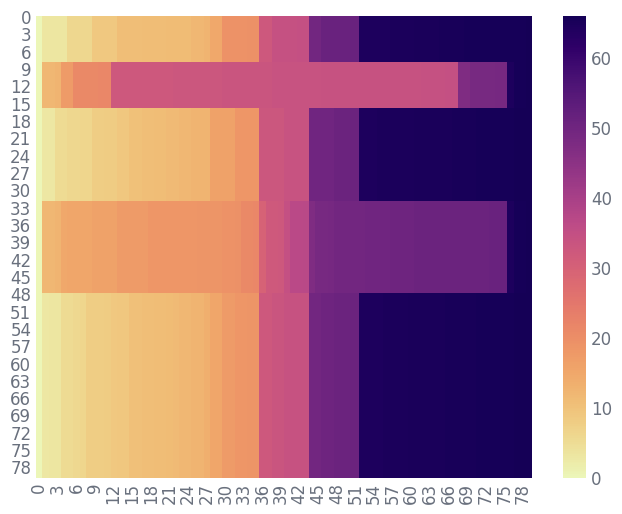

In [97]:
dm = mat.distance_matrix.round(2)
sns.heatmap(np.sort(dm, axis=1), cmap='rho_heatmap')

In [ ]:
sns.displot(rads, discrete=True)

In [ ]:
# import torch

# data = torch.load('data/checkpoint_sevennet_0.pth', map_location=torch.device('cpu'))

# params = data['model_state_dict']
# for k, v in params.items():
#     params[k] = params[k].cpu().detach().numpy()

# np.save('data/sevennet_ckpt.npy', params)

In [3]:
import treescope as tz

tz.basic_interactive_setup()

In [ ]:
params = np.load('data/sevennet_ckpt.npy', allow_pickle=True).item()

for k, v in params.items():
    if v.size == 0:
        params[k] = None

params